<a href="https://colab.research.google.com/github/sanikak96/Data-Science-Projects/blob/master/LSTMMusicGenreClassificationUsingMFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experimennt 4: Music Genre Classification using MFCCs - LSTM
I have implemented a Long Short Term Memory(LSTM), which is a bit more complex than simple RNN for music genre classification. The GTZAN music dataset is used to train the model and the Librosa library to extract audio features, i.e. the Melfrequency cepstral coefficients (MFCC), from the raw data. The extracted features are input to the Long Short Term Memory (LSTM) neural network model for training. The LSTM are built with Keras and Tensorflow.

### Importing the necessary Libraries

In [ ]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import load_model

### Downloading the dataset

Note: Upload the kaggle.json file before execution.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/  #kaggle.json is my API key. 
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification
!rm -r gtzan-dataset-music-genre-classification.zip

In [ ]:
# Remove corrupt file
os.remove('Data/genres_original/jazz/jazz.00054.wav')

### Creating Dataset with Audio and MFCC
I am going to continue using the augmented audio files by chopping the original audio files into slices. However, since not all audio files are exactly 30 sec long, I am picking a duration of 29 seconds.

In [ ]:
# Dataset location if the kaggle download is run
data_path = 'Data/genres_original/'

# Path where we wish to store the data after feature extraction
result_path = 'Data/data.json'

# As per my previous choice, I am pick a duration right under 30 seconds
sr = 22050
num_samples = 29 * sr

# Since the dataset contains 999 files, data augmentation is necessary.  
# Slicing the audio files:
slices = 10
samples_per_slice = int(num_samples / slices)

In [ ]:
def preprocess_data(data_path, result_path):

    # Let's create a dictionary of labels and processed data.
    feature_labels = {
        "labels": [],
        "mfcc": []
        }

    # Generating MFCCs for each audio sample after slicing it
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):

        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

            for s in range(slices):
                start_sample = samples_per_slice * s
                end_sample = start_sample + samples_per_slice
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13) #13 bands MFCCs
                mfcc = mfcc.T
                feature_labels["labels"].append(i-1)
                feature_labels["mfcc"].append(mfcc.tolist())

    # Saving the data to a .json file for future use.    
    with open(result_path, 'w') as f:
        json.dump(feature_labels, f)
    f.close()

In [ ]:
def load_data(result_path):

    with open(result_path, 'r') as f:
        data = json.load(f)
    f.close()
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print(X.shape)

    return X, y

In [ ]:
def prepare_datasets(X, y, split_size):
    
    # Creating a validation set and a test set.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size,random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size,random_state=0)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def genre_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape= input_shape, return_sequences=True),
        tf.keras.layers.LSTM(64),
        
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),


        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [ ]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock"
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("The model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [ ]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
preprocess_data(data_path, result_path)
inputs, targets = load_data(result_path)

(9990, 125, 13)


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(inputs, targets, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
model = genre_model(input_shape)

### Compling and Fitting the LSTM Model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc'] )

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 125, 64)           19968     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=30,
                        batch_size=32 )

Epoch 1/30
200/200 [==============================] - 17s 66ms/step - loss: 1.7695 - acc: 0.3609 - val_loss: 1.4754 - val_acc: 0.4755
Epoch 2/30
200/200 [==============================] - 12s 61ms/step - loss: 1.4311 - acc: 0.4869 - val_loss: 1.3088 - val_acc: 0.5425
Epoch 3/30
200/200 [==============================] - 12s 61ms/step - loss: 1.3102 - acc: 0.5348 - val_loss: 1.2785 - val_acc: 0.5521
Epoch 4/30
200/200 [==============================] - 12s 61ms/step - loss: 1.1990 - acc: 0.5806 - val_loss: 1.1780 - val_acc: 0.5881
Epoch 5/30
200/200 [==============================] - 12s 62ms/step - loss: 1.1124 - acc: 0.6075 - val_loss: 1.1190 - val_acc: 0.6081
Epoch 6/30
200/200 [==============================] - 12s 61ms/step - loss: 1.0353 - acc: 0.6396 - val_loss: 1.0911 - val_acc: 0.6221
Epoch 7/30
200/200 [==============================] - 12s 62ms/step - loss: 0.9686 - acc: 0.6623 - val_loss: 1.0701 - val_acc: 0.6336
Epoch 8/30
200/200 [==============================] - 12s 62ms

### Plotting the Accuracy Curves for LSTM

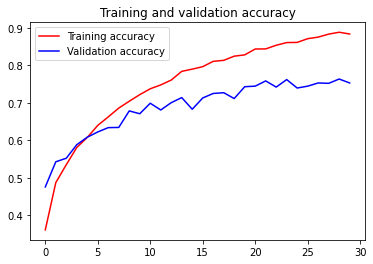

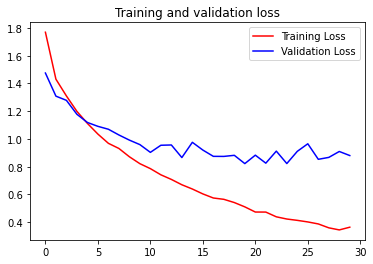

In [ ]:
plot_performance(history)

### Predictions on test data

In [ ]:
make_prediction(model, X_test, y_test, 24)

The model predicts: classical, and ground truth is: classical.



### Saving the Model for future use

In [ ]:
# save model
model.save('genreModelMfccLSTM.h5')
print('Model Saved!')

# load model
savedModel=load_model('genreModelMfccLSTM.h5')
savedModel.summary()

Model Saved!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 125, 64)           19968     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


### Checking predictions on the saved model

In [ ]:
make_prediction(savedModel, X_test, y_test, 105)

The model predicts: reggae, and ground truth is: reggae.



In [ ]:
make_prediction(savedModel, X_test, y_test, 100)

The model predicts: metal, and ground truth is: hiphop.



### Conclusion

There are mainly two types of genre in the dataset: strong and mild classes. The strong class have high amplitude which includes hip-hop, pop, reggae, metal and rock. And on the other hand the mild class have low amplitude which includes disco, blues, country, jazz and classical. Due to this, the classification of music into genres is not an easy task. However, LSTM performs quite well on classification.

On the training dataset, the model achieved an accuracy of 88.33% on the training data, it had an accuracy of 75.28% at the end of 30 epochs for test data. This model performs comparable to the CNN for MFCC features.